# Importing essential libraries 

In [7]:
import pandas as pd
from datetime import datetime,timedelta
import csv

# Reading the sample data

In [8]:
trans_data = pd.read_csv('Data_Files\\test_data.csv')

In [9]:
sus_days=2
data_size=len(trans_data.index)
start_date=datetime.strptime(trans_data['Date'][0], '%d-%m-%Y').date()
one_day=timedelta(days=1)
sus_day_dt=timedelta(days=sus_days-1)

# Detecting Circular Transactions

In [10]:
curr_date=start_date
suspect_trans=pd.DataFrame(columns=['TransactionID','SellerID','BuyerID','Amount(INR)'])
final_circ_trans=pd.DataFrame(columns=['TransactionID','SellerID','BuyerID','Amount(INR)'])
next_date_ptr=-1

end_flag=0
i=-1
while i < (data_size):
    i=i+1
    if(i==data_size):
        end_flag=1
    if(end_flag==0):
        read_date=datetime.strptime(trans_data['Date'][i], '%d-%m-%Y').date()
    if(end_flag==0 and curr_date <= read_date <= curr_date+sus_day_dt):
        suspect_trans=suspect_trans.append(trans_data.loc[i])
        if(read_date==curr_date+one_day and next_date_ptr==-1):
            next_date_ptr=i
        continue
    else:
        curr_date = read_date
        i=i-1
        if(next_date_ptr!=-1):
            curr_date=curr_date+one_day
            i=next_date_ptr-1
            next_date_ptr=-1
        
        suspect_trans.reset_index(drop=True, inplace=True)

        # Variable to keep track of change in number of suspicious transactions
        change = 1
        flag = 1    #Keeps track of number of iterations

        # Empty variable to store circular transaction
        circular_trans = []

        # Iterate till the number of suspicious and circular transactions are same
        while not change == 0:
            circular_trans = []
            
            # Print iterations and number of suspicious transaction at every iteration
            print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
            
            # Checking whether the buyers are also the sellers
            is_seller = suspect_trans['SellerID'].isin(suspect_trans['BuyerID'].unique())
            circular_trans.extend(suspect_trans[is_seller]['TransactionID'])
            
            change = len(suspect_trans) - len(circular_trans)
            
            # Now all the circular transactions are suspicious
            suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
            suspect_trans.reset_index(drop=True, inplace=True)
            flag += 1
            
        # Testing in inverse manner
        change = 1
        while not change == 0:
            circular_trans = []
            print("Iteration : ",flag,", No. of suspicious transactions : ",len(suspect_trans))
            is_buyer = suspect_trans['BuyerID'].isin(suspect_trans['SellerID'].unique())
            circular_trans.extend(suspect_trans[is_buyer]['TransactionID'])
            change = len(suspect_trans) - len(circular_trans)
            suspect_trans = suspect_trans.loc[suspect_trans['TransactionID'].isin(circular_trans)]  
            suspect_trans.reset_index(drop=True, inplace=True)
            flag += 1

        # Now we have the list of transactions that can make the loop
        final_circ_trans = final_circ_trans.append(suspect_trans)
        suspect_trans = suspect_trans.drop(suspect_trans.index, inplace=False)
        if(end_flag):
            break



Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  0
Iteration :  3 , No. of suspicious transactions :  0
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  1
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  0
Iteration :  3 , No. of suspicious transactions :  0
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  0
Iteration :  3 , No. of suspicious transactions :  0
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  0
Iteration :  3 , No. of suspicious transactions :  0
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transactions :  0
Iteration :  3 , No. of suspicious transactions :  0
Iteration :  1 , No. of suspicious transactions :  1
Iteration :  2 , No. of suspicious transaction

C:\Users\raagh\AppData\Local\Temp\ipykernel_4860\1090053232.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  suspect_trans=suspect_trans.append(trans_data.loc[i])
C:\Users\raagh\AppData\Local\Temp\ipykernel_4860\1090053232.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_circ_trans = final_circ_trans.append(suspect_trans)
C:\Users\raagh\AppData\Local\Temp\ipykernel_4860\1090053232.py:15: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  suspect_trans=suspect_trans.append(trans_data.loc[i])
C:\Users\raagh\AppData\Local\Temp\ipykernel_4860\1090053232.py:67: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  final_circ_trans = final_c

# A look at the circular transactions

In [11]:
final_circ_trans.drop_duplicates(inplace=True)
final_circ_trans.reset_index(drop=True, inplace=True)
final_circ_trans

,TransactionID,SellerID,BuyerID,Amount(INR),Date
0,txn_5,7,7,50,17-09-2012
1,txn_9,6,6,90,31-10-2014


# Lets plot and see in the directed graphs

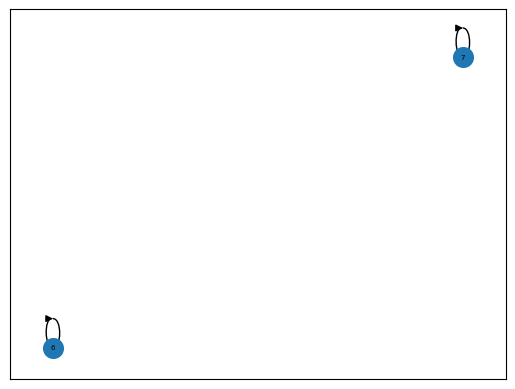

In [12]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt

def generate_multidirected_graph_image(trades_df):
    # Create a multidigraph using NetworkX
    graph = nx.DiGraph()
    for i, row in trades_df.iterrows():
        buyer, seller, amount, time = row['BuyerID'], row['SellerID'], row['Amount(INR)'], row['Date']
        if(graph.has_edge(buyer,seller)):
            graph[buyer][seller]['amount']=amount+graph[buyer][seller]['amount']
            continue
        graph.add_edge(buyer, seller, amount=amount)

    # Plot the graph
    #nodes
    G=graph
    pos=nx.spring_layout(G)
    fig, ax = plt.subplots()
    nx.draw_networkx_nodes(G, pos, ax=ax, node_size=200)
    nx.draw_networkx_labels(G, pos, ax=ax,font_size=5)
    #edges
    curved_edges = [edge for edge in G.edges() if reversed(edge) in G.edges()]
    straight_edges = list(set(G.edges()) - set(curved_edges))
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=straight_edges)
    arc_rad = 0.3
    nx.draw_networkx_edges(G, pos, ax=ax, edgelist=curved_edges, connectionstyle=f'arc3, rad = {arc_rad}')
    #adding labels
    import my_networkx as my_nx
    edge_weights = nx.get_edge_attributes(G,'amount')
    curved_edge_labels = {edge: edge_weights[edge] for edge in curved_edges}
    straight_edge_labels = {edge: edge_weights[edge] for edge in straight_edges}
    my_nx.my_draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=curved_edge_labels,rotate=False,rad = arc_rad, font_size=4)
    nx.draw_networkx_edge_labels(G, pos, ax=ax, edge_labels=straight_edge_labels,rotate=False, font_size=6)
    # fig.savefig("Graph_Visualization.png", bbox_inches='tight',pad_inches=0)
    plt.show()


# Load the trades data into a pandas DataFrame
trades_df = final_circ_trans

# Call the generate_multidirected_graph_image function
generate_multidirected_graph_image(trades_df)
